# TSD Models HyperPrams Analysis

Notebook to deal with TSD models trained on Comet.<br>
The aims are:
- to get best hyper-params run by Comet.
- to evaluate the single TSD Models (for season, trend and residual) and the TSD Aggregation Model.

The best hyper-params for each model and cluster are then used in the /fine-tuning folder to train optimized models.

<h3>Imports</h3>

In [1]:
import os
import random
import calendar
import datetime
import warnings
import logging
import ast
import numpy as np
import pandas as pd
from datetime import timedelta
from collections import Counter
from google.cloud import bigquery
import plotly.express as px
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
import comet_ml
from comet_ml import Experiment, Optimizer
import scipy.stats
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import pprint

logging.getLogger("comet_ml").setLevel("ERROR")

warnings.filterwarnings("ignore")
tqdm.pandas()

<h3>Config</h3>

In [2]:
# Config

PROJECT_ID = 'arpae-prod-ml'

# BigQuery
BQ_DATASET = 'SAMPLE_DATA'
JOINED_BQ_DATASET = 'JOINED_DATA'

# Layout
COLOR_PALETTE = px.colors.qualitative.Prism

SEASON_PARAMS = ['batch_size', 'dropout', 'layer_dense_units', 'layer_lstm_1_units', 
                 'layer_lstm_2_units', 'learning_rate', 'sequence_len']
TREND_PARAMS = ['batch_size', 'dropout', 'layer_dense_units', 'layer_lstm_1_units', 
                 'layer_lstm_2_units', 'learning_rate', 'sequence_len']
RESIDUAL_PARAMS = ['attention_key_dim', 'batch_size', 'dropout', 'layer_dense_1_units',
                   'layer_dense_2_units', 'layer_dense_3_units', 'learning_rate']

# Comet Params
COMET_API_KEY = 'B4Tttbbx4JrwXD9x2HBNjCdXX'
COMET_WORKSPACE = 'pveronesi' 
COMET_EXPERIMENT_SEASON_FT = 'arpae-tsd-season-finetuning'
COMET_EXPERIMENT_TREND_FT = 'arpae-tsd-trend-finetuning'
COMET_EXPERIMENT_RESIDUAL_FT = 'arpae-tsd-residual-finetuning'

# Paths
OPT_PARAMS_SEASON = "../../data/optimal_params_season.csv"
OPT_PARAMS_TREND = "../../data/optimal_params_trend.csv"
OPT_PARAMS_RESIDUAL = "../../data/optimal_params_residual.csv"

SEASON_OUTPUT_CLUSTER_FILENAME = "../../data/clustering_season_intervals.csv"
TREND_OUTPUT_CLUSTER_FILENAME = "../../data/clustering_trend_intervals.csv" 
RESIDUAL_OUTPUT_CLUSTER_FILENAME = "../../data/clustering_residual_intervals.csv"


<h3>Methods</h3>

In [3]:
def _run_query(client, query):
    df = client.query(query).to_dataframe()
    return df

def _read_table(client, project_id, dataset, table):
    query = "SELECT * FROM `{}.{}.{}` ".format(project_id, dataset, table)
    df = _run_query(client, query)
    return df

def _read_table_delta(client, project_id, dataset, table, date_col, init, end):
    query = "SELECT * FROM `{}.{}.{}` WHERE {} > '{}' AND {} < '{}' ".format(project_id, dataset, table, date_col, init, date_col, end)
    df = _run_query(client, query)
    if 'reftime' in df.columns:
        df.sort_values(by='reftime', inplace=True)
    elif date_col in df.columns:
        df.sort_values(by=date_col, inplace=True)
    else:
        return None
    return df


In [4]:
def _get_experiments_df(comet_experiment, comet_workspace):    
    # Get experiments
    comet_ml_api = comet_ml.api.API(api_key=COMET_API_KEY)
    experiments = comet_ml_api.get_experiments(project_name=comet_experiment, workspace=comet_workspace)
    # Get experiments Params & Values
    experiments_df = []
    for experiment in experiments:
        # Get experiment details
        model_name, loss_name, cluster_id, exp_id = experiment.name.split("-")
        res = {"model_name": model_name,
               "cluster_id": cluster_id.replace("Cluster", ""),
               "exp_id": int(exp_id.replace("Exp", ""))}
        # Get hyperparameters
        try:
            hyperparams = ast.literal_eval([x['valueCurrent'] for x in experiment.get_others_summary() 
                                            if x['name'] == 'optimizer_parameters'][0])
            for name, value in hyperparams.items():
                res[name] = value
        except:
            continue
        # Get mse on test set
        try:
            test_error = [x['valueCurrent'] for x in experiment.get_others_summary() 
                          if x['name'] == 'test-error'][0]
        except: 
            test_error = 0.0
        res["test_error"] = np.round(float(test_error), 4)
        # Append experiment result
        experiments_df.append(res)
    experiments_df = pd.DataFrame(experiments_df)
    return experiments_df

def _get_best_cluster_params(experiments_df):
    # Get Best Run for each Cluster
    experiments_df = experiments_df.sort_values("test_error").groupby("cluster_id", as_index=False).first()
    experiments_df['dropout'] = experiments_df['dropout'].round(1)
    experiments_df['learning_rate'] = experiments_df['learning_rate'].round(4)
    return experiments_df

def _get_best_global_params(experiments_df, params):
    opt_params_global = {}
    for param in params:
        max_count = experiments_df[param].value_counts().max()
        max_count_idx = experiments_df[param].value_counts() == max_count
        opt_params_global[param] = experiments_df[param].value_counts()[max_count_idx].index.max()
    return opt_params_global

def _plot_cluster_error(experiments_df):
    plt.figure(figsize=(15, 3))
    plt.title("Test Error per Cluster; Mean = {}".format(experiments_df['test_error'].mean()))
    bars = plt.bar(experiments_df['cluster_id'], 
                   experiments_df['test_error'])
    for rect in bars:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height + 0.05, 
                 np.round(rect.get_height(), 3), ha='center', va='bottom')
    plt.hlines(experiments_df['test_error'].mean(), xmin=-0.4, xmax=9.4, linestyles='--', 
               colors='orange', label='mean test error')
    plt.ylim(0, 1)
    plt.xlabel('Cluster id')
    plt.ylabel('test error')
    plt.legend()
    plt.show()

def _plot_params_distribution(experiments_df, params):
    rows, cols = 3, 3
    fig, axs = plt.subplots(rows, cols, figsize=(16,8), squeeze=False)
    for subpltn, param in enumerate(params):
        ax = axs[divmod(subpltn, cols)]
        ax.set_title(param)
        ax.grid(alpha=.3)
        sns.countplot(data=experiments_df, x=param, ax=ax)
        # removing empty plots from subplot grid
    for subpltn in range(subpltn+1, rows*cols): fig.delaxes(axs.flatten()[subpltn]) 
    plt.tight_layout()
    plt.show()

def _evaluate_experiment(experiment_id, params):
    # Get Experiments
    comet_ml_api = comet_ml.api.API(api_key=COMET_API_KEY)
    experiments_df = _get_experiments_df(experiment_id, COMET_WORKSPACE)
    # Get Optimal Params for each cluster
    experiments_df = _get_best_cluster_params(experiments_df)
    # Get Optimal Global Params
    opt_params_global = _get_best_global_params(experiments_df, params)    
    # Plot Cluster Error
    _plot_cluster_error(experiments_df)
    # Plot Params Distribution
    _plot_params_distribution(experiments_df, params)
    return experiments_df, opt_params_global


<h3>1. Config</h3>

<h4>1.1 Config BigQuery</h4>

In [5]:
# Setup Client

bq_client = bigquery.Client(project=PROJECT_ID)
bq_client

<h3>2. Evaluate HyperPrameter-Tuning</h3>

<h4>2.1 Get Optimal Params</h4>

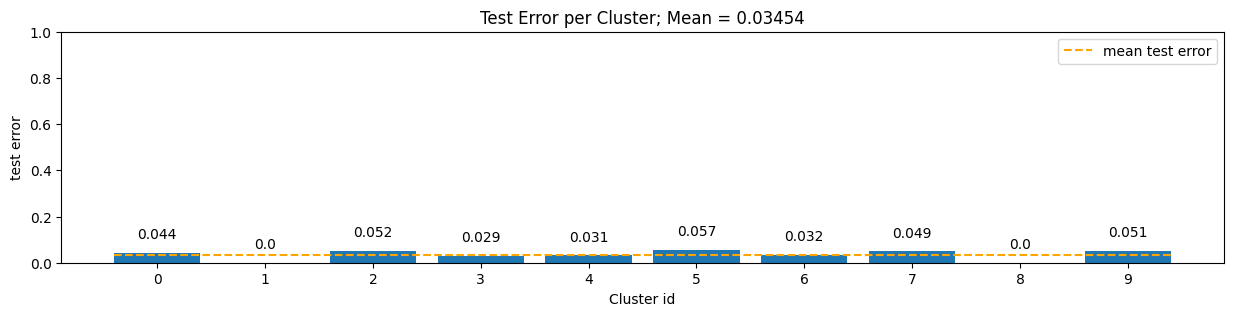

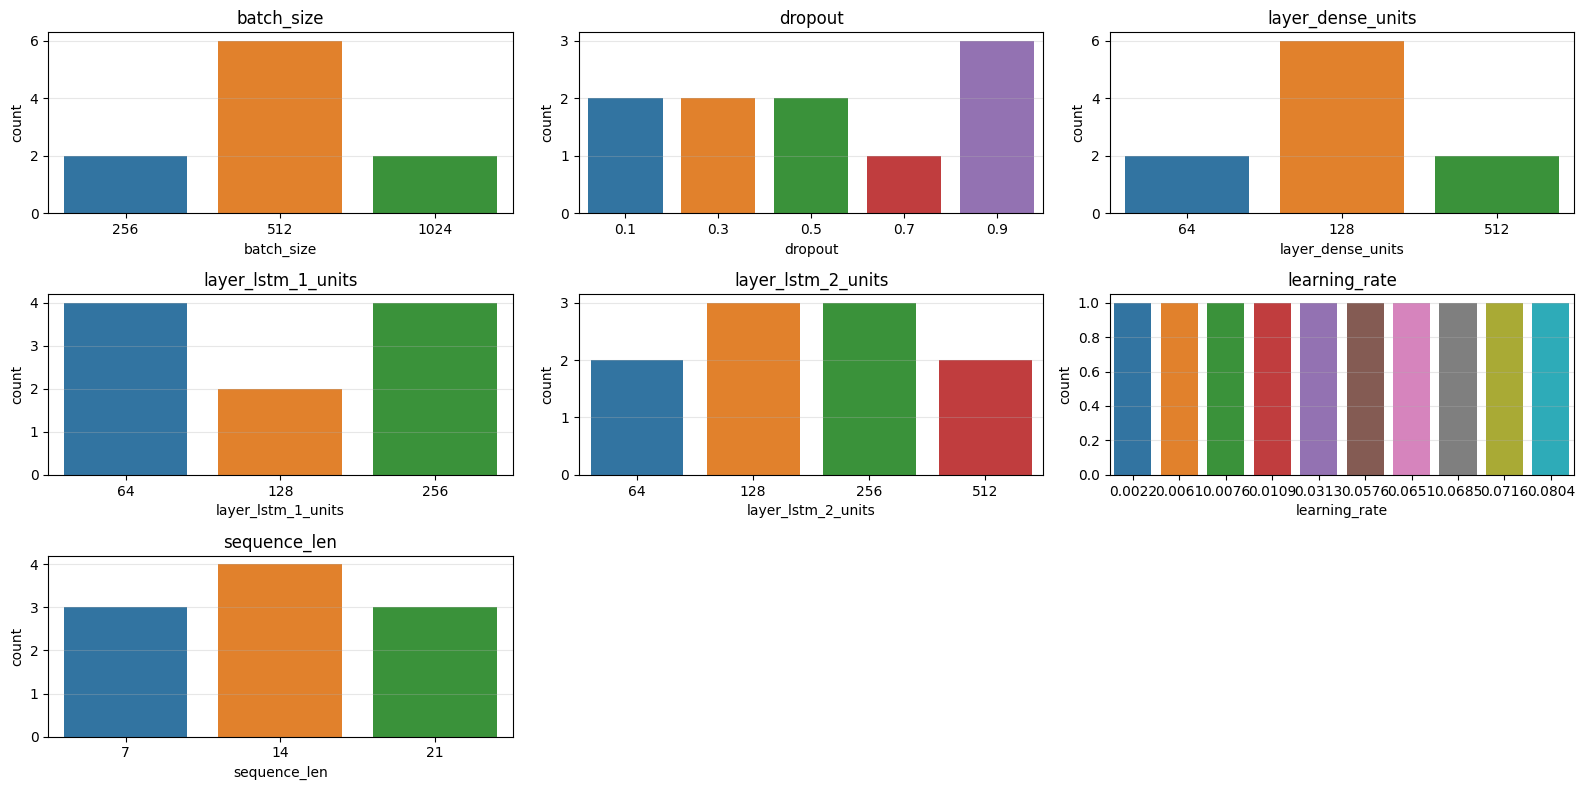

Optimal Global Params:
{'batch_size': 512,
 'dropout': 0.9,
 'layer_dense_units': 128,
 'layer_lstm_1_units': 256,
 'layer_lstm_2_units': 256,
 'learning_rate': 0.0804,
 'sequence_len': 14}


In [6]:
# Evaluate Season Experiment

season_experiments_df, season_opt_params_global = _evaluate_experiment(COMET_EXPERIMENT_SEASON_FT, SEASON_PARAMS)
print("Optimal Global Params:")
pprint.pprint(season_opt_params_global)    
#season_experiments_df

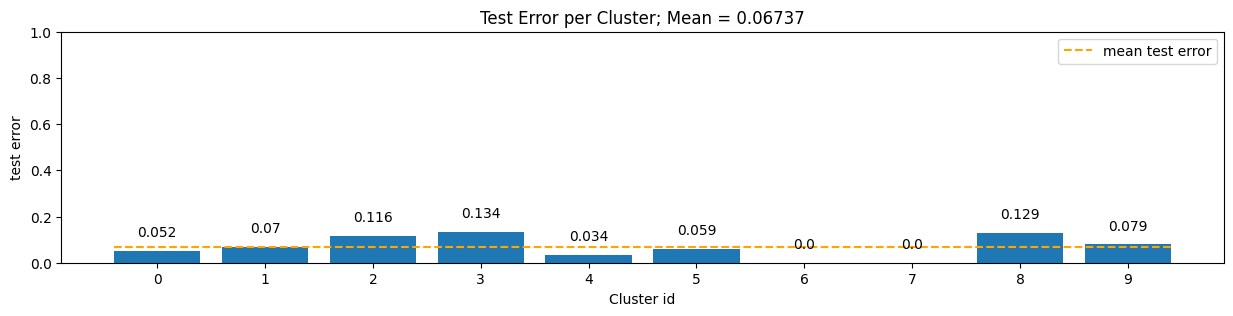

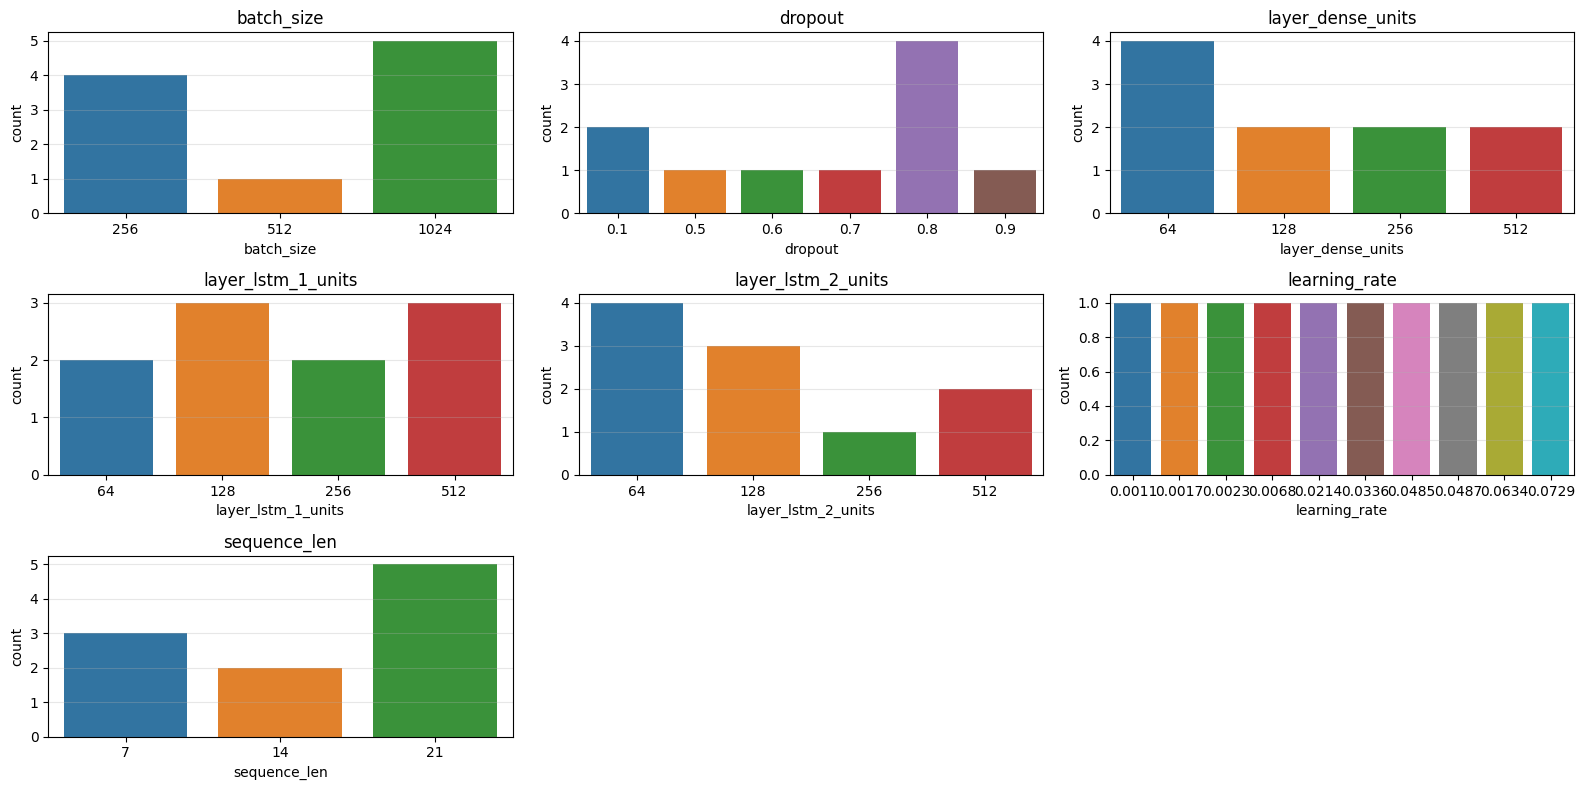

Optimal Global Params:
{'batch_size': 1024,
 'dropout': 0.8,
 'layer_dense_units': 64,
 'layer_lstm_1_units': 512,
 'layer_lstm_2_units': 64,
 'learning_rate': 0.0729,
 'sequence_len': 21}


In [7]:
# Evaluate Trend Experiment

trend_experiments_df, trend_opt_params_global = _evaluate_experiment(COMET_EXPERIMENT_TREND_FT, TREND_PARAMS)
print("Optimal Global Params:")
pprint.pprint(trend_opt_params_global)    
#trend_experiments_df

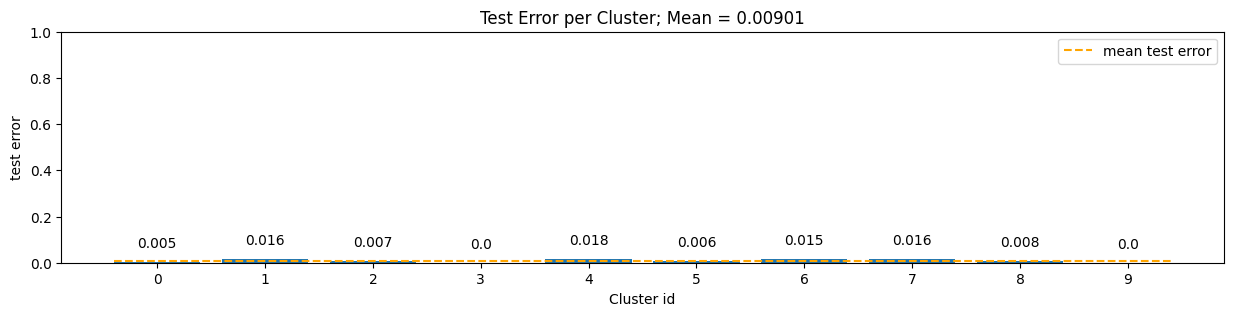

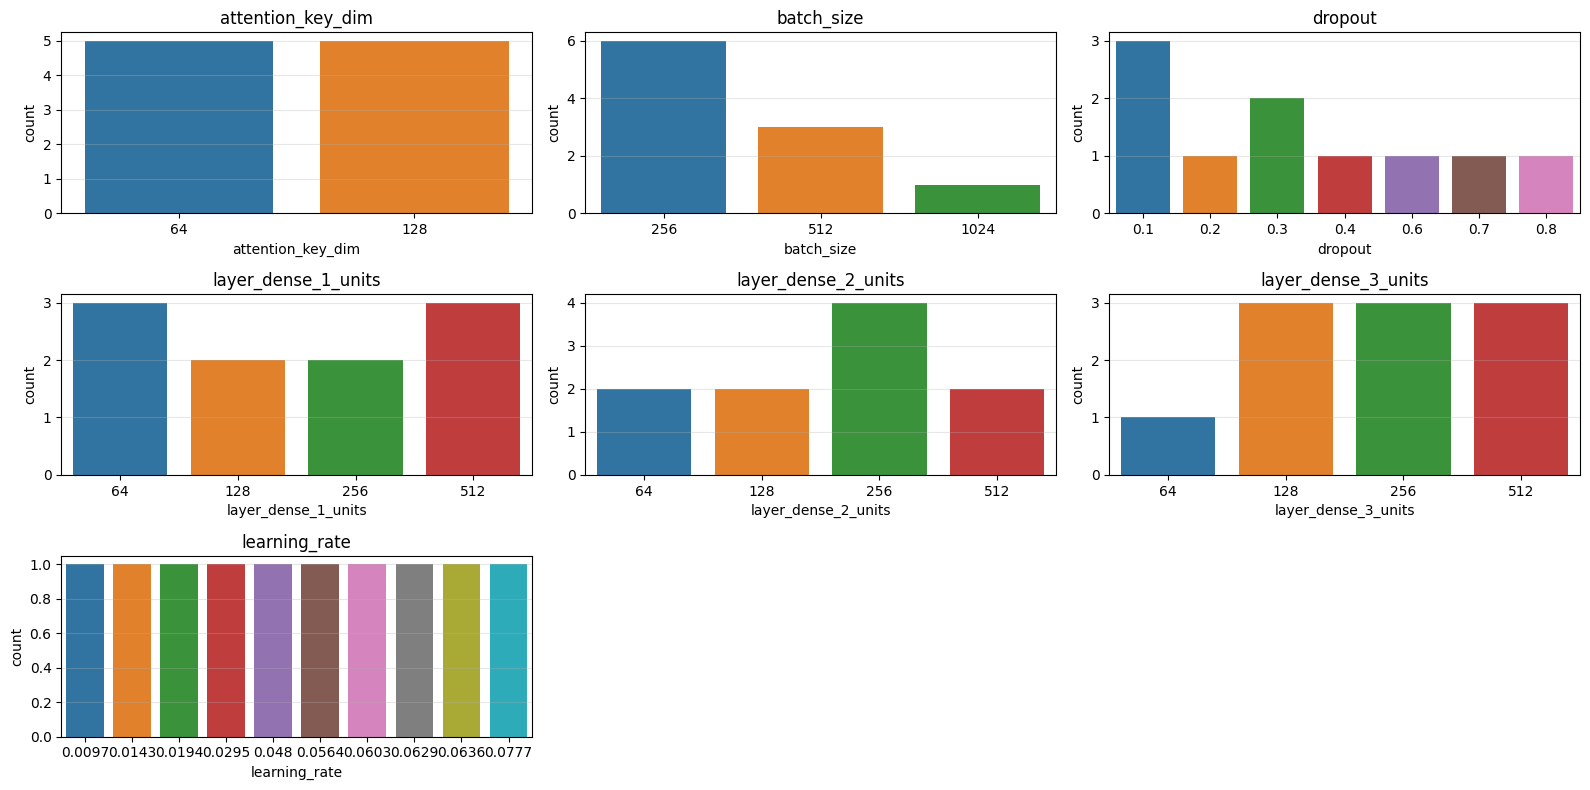

Optimal Global Params:
{'attention_key_dim': 128,
 'batch_size': 256,
 'dropout': 0.1,
 'layer_dense_1_units': 512,
 'layer_dense_2_units': 256,
 'layer_dense_3_units': 512,
 'learning_rate': 0.0777}


In [8]:
# Evaluate Residual Experiment

residual_experiments_df, residual_opt_params_global = _evaluate_experiment(COMET_EXPERIMENT_RESIDUAL_FT, 
                                                                           RESIDUAL_PARAMS)
print("Optimal Global Params:")
pprint.pprint(residual_opt_params_global)    
#residual_experiments_df

In [9]:
# Per-Cluster Season Best params

season_experiments_df

,cluster_id,model_name,exp_id,batch_size,dropout,layer_dense_units,layer_lstm_1_units,layer_lstm_2_units,learning_rate,sequence_len,test_error
0,0,LSTM_base,7,512,0.9,128,64,256,0.0576,14,0.0441
1,1,LSTM_base,10,512,0.7,128,256,256,0.0313,21,0.0000
2,2,LSTM_base,6,512,0.3,128,128,128,0.0804,14,0.0522
3,3,LSTM_base,5,512,0.1,512,64,512,0.0651,7,0.0288
4,4,LSTM_base,5,256,0.1,64,64,128,0.0716,7,0.0314
5,5,LSTM_base,8,512,0.9,128,256,128,0.0022,14,0.0570
6,6,LSTM_base,9,1024,0.5,64,128,64,0.0076,7,0.0321
7,7,LSTM_base,7,256,0.5,512,256,256,0.0061,21,0.0488
8,8,LSTM_base,5,512,0.9,128,256,512,0.0685,21,0.0000
9,9,LSTM_base,5,1024,0.3,128,64,64,0.0109,14,0.0510


In [10]:
# Per-Cluster Trend Best params

trend_experiments_df

,cluster_id,model_name,exp_id,batch_size,dropout,layer_dense_units,layer_lstm_1_units,layer_lstm_2_units,learning_rate,sequence_len,test_error
0,0,LSTM_Attention_v1,2,1024,0.1,64,512,256,0.0023,7,0.0520
1,1,LSTM_Attention_v1,8,1024,0.6,128,256,128,0.0068,21,0.0699
2,2,LSTM_Attention_v1,4,256,0.9,512,128,64,0.0485,7,0.1165
3,3,LSTM_Attention_v1,7,512,0.8,128,256,128,0.0214,21,0.1345
4,4,LSTM_Attention_v1,9,1024,0.1,64,128,64,0.0017,14,0.0337
5,5,LSTM_Attention_v1,1,1024,0.8,256,512,512,0.0011,21,0.0594
6,6,LSTM_Attention_v1,2,256,0.7,512,64,128,0.0634,21,0.0000
7,7,LSTM_Attention_v1,1,1024,0.5,64,64,512,0.0487,21,0.0000
8,8,LSTM_Attention_v1,2,256,0.8,64,128,64,0.0336,14,0.1287
9,9,LSTM_Attention_v1,8,256,0.8,256,512,64,0.0729,7,0.0790


In [11]:
# Per-Cluster Residual Best params

residual_experiments_df

,cluster_id,model_name,exp_id,attention_key_dim,batch_size,dropout,layer_dense_1_units,layer_dense_2_units,layer_dense_3_units,learning_rate,test_error
0,0,Attention_base,8,64,256,0.3,256,64,128,0.0480,0.0046
1,1,Attention_base,5,128,256,0.1,256,256,256,0.0629,0.0160
2,2,Attention_base,8,128,512,0.1,512,256,256,0.0295,0.0068
3,3,Attention_base,8,64,256,0.3,64,512,128,0.0603,0.0000
4,4,Attention_base,2,128,256,0.8,512,64,128,0.0636,0.0177
5,5,Attention_base,8,64,512,0.1,512,512,512,0.0194,0.0062
6,6,Attention_base,8,64,256,0.4,128,256,256,0.0777,0.0150
7,7,Attention_base,5,64,512,0.7,128,256,512,0.0097,0.0160
8,8,Attention_base,7,128,256,0.6,64,128,64,0.0143,0.0078
9,9,Attention_base,10,128,1024,0.2,64,128,512,0.0564,0.0000


<h4>4.2 Save Per-Cluster Best Params</h4>

Since we've found the best params for-each cluster, we can save as csv files, in order to be used in the experimental notebook to re-train models.

In [12]:
# Save as CSVs

season_experiments_df.to_csv(OPT_PARAMS_SEASON, index=False)
trend_experiments_df.to_csv(OPT_PARAMS_TREND, index=False)
residual_experiments_df.to_csv(OPT_PARAMS_RESIDUAL, index=False)